# LETR Basic Usage Demo

In [30]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import torchvision.transforms.functional as functional
import torch.nn.functional as F
from models import build_model
from util.misc import nested_tensor_from_tensor_list

In [31]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)
        return image

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        for t in self.transforms:
            format_string += "\n"
            format_string += "    {0}".format(t)
        format_string += "\n)"
        return format_string

class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        image = functional.normalize(image, mean=self.mean, std=self.std)
        return image

class ToTensor(object):
    def __call__(self, img):
        return functional.to_tensor(img)

def resize(image, size, max_size=None):
    # size can be min_size (scalar) or (w, h) tuple
    def get_size_with_aspect_ratio(image_size, size, max_size=None):
        w, h = image_size
        if max_size is not None:
            min_original_size = float(min((w, h)))
            max_original_size = float(max((w, h)))
            if max_original_size / min_original_size * size > max_size:
                size = int(round(max_size * min_original_size / max_original_size))
        if (w <= h and w == size) or (h <= w and h == size):
            return (h, w)
        if w < h:
            ow = size
            oh = int(size * h / w)
        else:
            oh = size
            ow = int(size * w / h)
        return (oh, ow)

    def get_size(image_size, size, max_size=None):
        if isinstance(size, (list, tuple)):
            return size[::-1]
        else:
            return get_size_with_aspect_ratio(image_size, size, max_size)

    size = get_size(image.size, size, max_size)
    rescaled_image = functional.resize(image, size)

    return rescaled_image

class Resize(object):
    def __init__(self, sizes, max_size=None):
        assert isinstance(sizes, (list, tuple))
        self.sizes = sizes
        self.max_size = max_size

    def __call__(self, img):
        size = self.sizes
        return resize(img, size, self.max_size)



## Load Model Pre-trained Weights

In [32]:
# obtain checkpoints
checkpoint = torch.load('../exp/res101_stage2_focal/checkpoints/checkpoint0024.pth', map_location='cpu')

# load model
args = checkpoint['args']
model, _, postprocessors = build_model(args)
model.load_state_dict(checkpoint['model'])
model.eval()



LETRstack(
  (letr): LETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
          (1): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
            )
            (linear1): 

## Load Demo Image

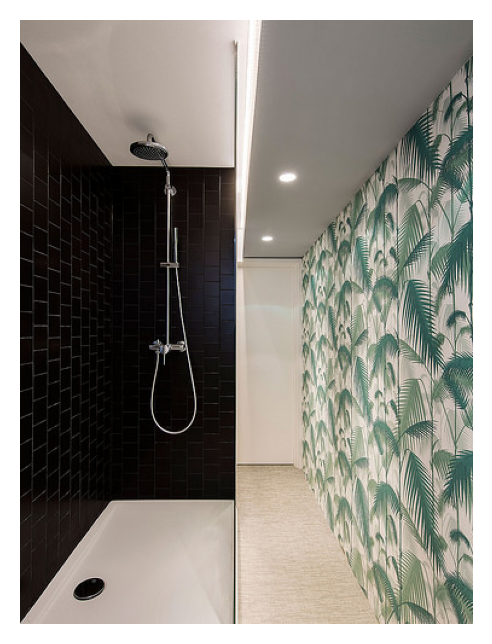

In [33]:
# load image
raw_img = plt.imread('../figures/demo.png')
h, w = raw_img.shape[0], raw_img.shape[1]
orig_size = torch.as_tensor([int(h), int(w)])

# normalize image
test_size = 1100
normalize = Compose([
        ToTensor(),
        Normalize([0.538, 0.494, 0.453], [0.257, 0.263, 0.273]),
        Resize([test_size]),
    ])
img = normalize(raw_img)
inputs = nested_tensor_from_tensor_list([img])
plt.axis('off')
plt.imshow(raw_img)

## Model Inference

In [34]:

outputs = model(inputs)[0]

## Post-processing Results

In [35]:
out_logits, out_line = outputs['pred_logits'], outputs['pred_lines']
prob = F.softmax(out_logits, -1)
scores, labels = prob[..., :-1].max(-1)
img_h, img_w = orig_size.unbind(0)
scale_fct = torch.unsqueeze(torch.stack([img_w, img_h, img_w, img_h], dim=0), dim=0)
lines = out_line * scale_fct[:, None, :]
lines = lines.view(1000, 2, 2)
lines = lines.flip([-1])# this is yxyx format
scores = scores.detach().numpy()
keep = scores >= 0.7
keep = keep.squeeze()
lines = lines[keep]
lines = lines.reshape(lines.shape[0], -1)




## Plot Inference Results

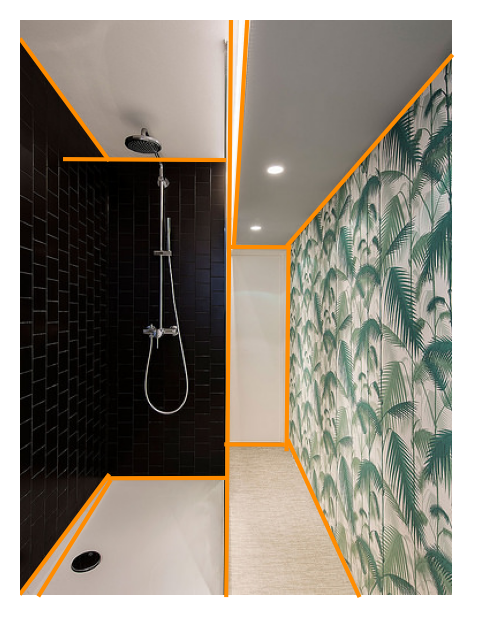

In [41]:

fig = plt.figure()
plt.imshow(raw_img)
for tp_id, line in enumerate(lines):
    y1, x1, y2, x2 = line # this is yxyx
    p1 = (x1, y1)
    p2 = (x2, y2)
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=1.5, color='darkorange', zorder=1)
plt.axis('off')


#plt.savefig("../figures/demo_result.png", dpi=300, bbox_inches='tight', pad_inches = 0)
#plt.close(fig)
plt.show()


In [38]:
plt.show()